# Combustion and Air Pollution HW #6

#### Consider combustion of n-heptane ($C_7H_{16}$). Heptane and air are introduced to a constant volume chamber. First let's consider $\phi$ = 1.0 and atmospheric pressure. Upon ignition, combustion of the premixed fuel/air occurs at constant volume and constant internal energy (assuming that the chamber is adiabatic).

#### Calculate:
1. The adiabatic flame temperature if the fuel and air are preheated and introduced into the chamber at 500 K. 
2. The NOx concentration at equlibrium for $\phi$ = 0.7, 1.0, and 1.3

In this homework we will use more detailed combustion chemistry then we previously considered in this class, along with the Zeldovich mechanism for thermal fixation of atmospheric N2, to model and predict NOx formation in heptane combustion.
We use an open source software tool called [Cantera](http://www.cantera.org/docs/sphinx/html/index.html) which helps us solve thermodynamics and kinetics problems.

This homework was adapted from a lecture in Prof. Richard West's undergraduate chemical kinetics class in the Department of Chemical Engineering as well as existing Python notebooks in the [cantera-jupyter project](https://github.com/cantera/cantera-jupyter). 

### Simply click inside the cells below to be able to type in and edit them, and press Shift+Enter to execute the code in a cell that is selected.

In [65]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import seaborn

The n-heptane ($C_7H_{16}$) mechanism we will consider is from the Lawrence Livermore National Lab (LLNL), with the 3-reaction Zeldovich mechanism manually added to it. First we create a Solution object in Cantera for n-heptane gas that includes all of the thermodynamic and kinetic parameters needed to describe its combustion. (Don't worry about the warning)

In [2]:
gas = ct.Solution('heptanesymp159.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in cp/R detected at Tmid = 1391
	Value computed using low-temperature polynomial:  53.0168.
	Value computed using high-temperature polynomial: 52.748.


We can print out some chemical species and reactions that are considered in the mechanism:

In [38]:
print "Some of the species in the mechanism:"
print " ".join(gas.species_names[:20])
print "\n"

print "Model includes reactions that break down the fuel ('nc7h16'):"
for i in range(1052,1102,5):
    print gas.reaction(i)
print "\n"

print "And also contains small molecule chemistry:"
for i in range(20):
    print gas.reaction(i)
print "\n"
print "There are {0} total reactions in this mechanism!".format(len(gas.reactions()))

Some of the species in the mechanism:
n2 ch3 h ch4 h2 oh h2o o c2h6 c2h5 hco co co2 o2 h2o2 ho2 c2h4 ch3oh ch2oh ch3o


Model includes reactions that break down the fuel ('nc7h16'):
nc7h16 => c7h15-1 + h
c7h15-3 + h => nc7h16
nc7h16 => c2h5 + c5h11-1
c7h15-1 + h2 => h + nc7h16
h + nc7h16 => c7h15-4 + h2
c7h15-2 + oh => nc7h16 + o
nc7h16 + oh => c7h15-1 + h2o
c7h15-3 + h2o => nc7h16 + oh
ho2 + nc7h16 => c7h15-2 + h2o2
c7h15-4 + h2o2 => ho2 + nc7h16


And also contains small molecule chemistry:
ch3 + h (+M) => ch4 (+M)
ch4 (+M) => ch3 + h (+M)
ch4 + h => ch3 + h2
ch3 + h2 => ch4 + h
ch4 + oh => ch3 + h2o
ch3 + h2o => ch4 + oh
ch4 + o => ch3 + oh
ch3 + oh => ch4 + o
c2h6 + ch3 => c2h5 + ch4
c2h5 + ch4 => c2h6 + ch3
hco + oh => co + h2o
co + h2o => hco + oh
co + oh => co2 + h
co2 + h => co + oh
h + o2 => o + oh
o + oh => h + o2
h2 + o => h + oh
h + oh => h2 + o
h2o + o => 2 oh
2 oh => h2o + o


There are 1543 total reactions in this mechanism!


Let's look at the last few reactions in the mechanism, representing the Zeldovich mechanism.

In [4]:
zeldovich = gas.reactions()[-3:]
for rxn in zeldovich:
    print rxn.equation, rxn.rate

n + no <=> n2 + o Arrhenius(A=2.7e+10, b=0, E=1.48532e+06)
n + o2 <=> no + o Arrhenius(A=9e+06, b=1, E=2.7196e+07)
n + oh <=> h + no Arrhenius(A=3.36e+10, b=0, E=1.61084e+06)


#### 1. Calculate the adiabatic flame temperature if the fuel and air are preheated and introduced into the chamber at 500 K. 
First, we need to initialize the fuel at the correct temperature (K), pressure (Pa) and mole fractions (these can be molar ratios, Cantera will normalize them, like in STANJAN).
Replace the "xxxx" with the correct number of moles.

In [68]:
gas.TPX = 500, 1e5, 'nc7h16:1.0,o2:11.0,n2:41.58'
#gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:xxxx,n2:xxxx'

We'll find the equilibrium flame temperature by equilibrating keeping volume and internal energy
constant.

In [69]:
gas.equilibrate('UV')
print "The adiabatic flame temperature is {0} K".format(int(round(gas.T)))

The adiabatic flame temperature is 2682 K


#### 2. Calculate the NOx concentration at equlibrium for $\phi$ = 0.7, 1.0, and 1.3
Change the numbers of moles for these equivalence ratios,below.

In [70]:
x_NO_stoich = gas['no'].X[0]

# For fuel lean case (0.7)
gas.TPX = 500, 1e5, 'nc7h16:1.0,o2:15.71,n2:59.4'
#gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:xxxx,n2:xxxx'
gas.equilibrate('UV')
x_NO_lean = gas['no'].X[0]

# For fuel rich case (1.3)
gas.TPX = 500, 1e5, 'nc7h16:1.0,o2:8.46,n2:31.98'
#gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:xxxx,n2:xxxx'
gas.equilibrate('UV')
x_NO_rich = gas['no'].X[0]

print "For fuel lean case, NO = {0} ppm".format(round(x_NO_lean*1e6, 1))
print "For stoichiometric case, NO = {0} ppm".format(round(x_NO_stoich*1e6, 1))
print "For fuel rich case, NO = {0} ppm".format(round(x_NO_rich*1e6, 1))

For fuel lean case, NO = 9137.0 ppm
For stoichiometric case, NO = 7226.4 ppm
For fuel rich case, NO = 1615.3 ppm


It may look like the NO is decreasing with equivalence ratio, but there is a maximum in the fuel lean region...

The NO is maximum at equivalence ratio 0.798


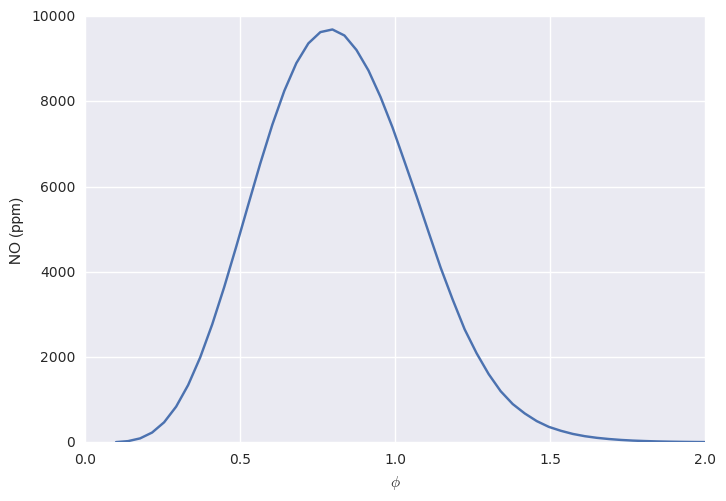

In [78]:
equivalence_ratios = np.linspace(0.1, 2, 50)
x_NO = np.zeros_like(equivalence_ratios)
for i, phi in enumerate(equivalence_ratios):
    mol_O2 = 11.0 / phi
    mol_N2 = 3.78 * mol_O2
    X_string = "nc7h16:1.0,o2:" + str(round(mol_O2, 2)) + ",n2:" + str(round(mol_N2, 2))
    gas.TPX = 500, 1e5, X_string
    gas.equilibrate('UV')
    x_NO[i] = gas['no'].X[0]
plt.plot(equivalence_ratios, x_NO*1E6)
plt.xlabel('$\phi$')
plt.ylabel('NO (ppm)')
print "The NO is maximum at equivalence ratio " + str(round(equivalence_ratios[np.argmax(x_NO)],3))

### Kinetics
We will burn the gas starting at the same temperature, but atmospheric pressure. This time we will hold volume constant using an ideal gas reactor, so pressure can change.
The following code will print out the simulation time along with temperature, pressure, and internal energy.

In [25]:
gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:11.0,n2:41.58'
#gas.TPX = 1000, 1e5, 'nc7h16:1.0,o2:xxxx,n2:xxxx' # fill in your calculated o2, n2 values.

reactor = ct.IdealGasReactor(gas)
reactor_network = ct.ReactorNet([reactor])

start_time = 0.0  #starting time
end_time = 0.5 # seconds
n_steps = 501
times = np.linspace(start_time, end_time, n_steps)
concentrations = np.zeros((n_steps, gas.n_species))
mole_frac = np.zeros((n_steps, gas.n_species))
pressures = np.zeros(n_steps)
temperatures = np.zeros(n_steps)

print_data = True
if print_data:
    #this just gives headings
    print('{0:>10s} {1:>10s} {2:>10s} {3:>14s}'.format(
            't [s]','T [K]','P [Pa]','u [J/kg]')) 

for n, time in enumerate(times):
    if time > 0:
        reactor_network.advance(time)
    temperatures[n] = reactor.T
    pressures[n] = reactor.thermo.P
    concentrations[n,:] = reactor.thermo.concentrations
    mole_frac[n,:] = gas.X
    if print_data:
        print('{0:10.3e} {1:10.3f} {2:10.3f} {3:14.6e}'.format(
                 reactor_network.time, reactor.T, reactor.thermo.P, reactor.thermo.u))

     t [s]      T [K]     P [Pa]       u [J/kg]
 0.000e+00   1000.000 100000.000   4.411596e+05
 1.000e-03    999.950  99996.869   4.411596e+05
 2.000e-03    999.865  99992.564   4.411596e+05
 3.000e-03    999.746  99987.409   4.411596e+05
 4.000e-03    999.594  99981.745   4.411596e+05
 5.000e-03    999.409  99975.879   4.411596e+05
 6.000e-03    999.192  99970.104   4.411596e+05
 7.000e-03    998.945  99964.722   4.411596e+05
 8.000e-03    998.670  99960.063   4.411596e+05
 9.000e-03    998.369  99956.491   4.411596e+05
 1.000e-02    998.044  99954.413   4.411596e+05
 1.100e-02    997.698  99954.297   4.411596e+05
 1.200e-02    997.334  99956.682   4.411596e+05
 1.300e-02    996.956  99962.206   4.411596e+05
 1.400e-02    996.570  99971.635   4.411596e+05
 1.500e-02    996.180  99985.904   4.411596e+05
 1.600e-02    995.794 100006.175   4.411596e+05
 1.700e-02    995.423 100033.917   4.411596e+05
 1.800e-02    995.076 100071.009   4.411596e+05
 1.900e-02    994.772 100119.895   4.411

#### c. What is the approximate ignition time? (hint: when do the temperature, pressure have the largest change?) Change initial temperature, pressure in the cell above, and comment on the change in ignition time.

The maximum mole fraction of NO is 1.09e-02


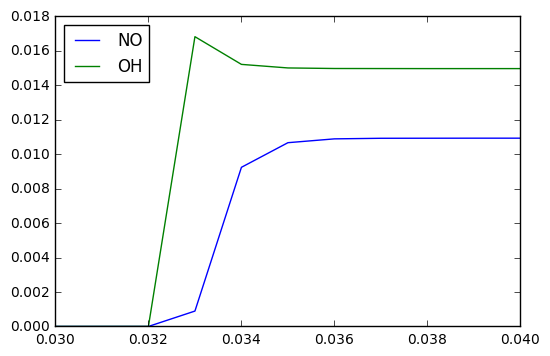

In [21]:
i_no = gas.species_names.index('no')
#i_o2 = gas.species_names.index('o2')
i_oh = gas.species_names.index('oh')
plt.plot(times, mole_frac[:,i_no], label='NO')
#plt.plot(times, mole_frac[:,i_o2], label='O2')
plt.plot(times, mole_frac[:,i_oh], label='OH')
plt.xlim(0.03, 0.04)
plt.legend(loc='best')
print "The maximum mole fraction of NO is {:.2e}".format(np.max(mole_frac[:,i_no]))

#### d. At what conditions can we achieve a maximum NO mole fraction of 0.005?

Just want to check at least one rate to make sure it's reasonably close to the one in the book...These came from the gri mech.

In [5]:
T = np.linspace(300,2500,100)

In [6]:
A = rxn.rate.pre_exponential_factor / 1000.0
n = rxn.rate.temperature_exponent
Ea = rxn.rate.activation_energy / 1000.0

In [7]:
rate_mech = A * T**n * np.exp(-Ea/8.314/T)
rate_book = 7.1E7 * np.exp(-450.0/T)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

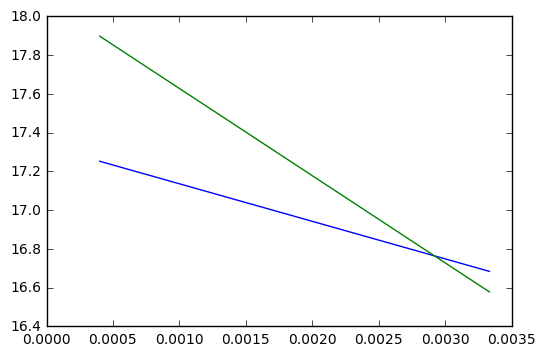

In [9]:
plt.plot(1.0/T, np.log(rate_mech))
plt.plot(1.0/T, np.log(rate_book))